In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import SimpleITK as sitk
from sklearn.model_selection import train_test_split
import re
import glob
import seaborn as sns

In [4]:
source_PI_CAI = r'Data/picai_public_images'
source_PI_CAI_whole_gland_Guerbet23 = r'Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23'
source_PI_CAI_Human = r'Data/picai_public_images/csPCa_lesion_delineations/human_expert/resampled'
source_PI_CAI_resampled = r'Data/t2w_spacing_resampled'
source_PI_CAI_resampled_whole_gland_Guerbet23 = r'Data/Guerbet23_resampled'
source_PI_CAI_resampled_Human = r'Data/Human_resampled'
marksheet_path = r'Data\marksheet.csv'

In [ ]:
def parse_gleason(gs):
    """Extract primary and secondary grades from a Gleason score string like '4+3'."""
    match = re.match(r'(\d+)\+(\d+)', gs)
    if match:
        primary, secondary = int(match.group(1)), int(match.group(2))
        return (primary + secondary, primary)  # prioritize higher total, then higher primary
    return (-1, -1)  # fallback for invalid patterns

def get_highest_gleason_score(gleason_scores):
    score_mapping = {
        "0+0": 0,
        "3+3": 1,
        "3+4": 2,
        "4+3": 3,
        "4+4": 4,
        "3+5": 5,
        "5+3": 6,
        "5+4": 7,
        "4+5": 8,
        "5+5": 9,
        "5+5": 10
    }
    return max(gleason_scores, key=lambda x: score_mapping.get(x, -1))

def is_csPCa(gs):
    try:
        total, primary = parse_gleason(gs)
        return int(total >= 7 and (primary == 4 or primary == 5))
    except:
        return 0

def find_t2W_files(dir, fileinfo):
    dir = os.path.normpath(dir)
    pattern = f"**/*{fileinfo}"  # Recursive glob pattern
    search_path = os.path.join(dir, pattern)
    t2w_file_paths = glob.glob(search_path, recursive=True)
    return t2w_file_paths

def preprocess_data(df):
    print(f"Initial dataset length: {len(df)}")

    # 1. Drop data with missing values in the column "PSA" or "Volume"
    df = df.dropna(subset=['psa'])
    print(f"Dataset length after dropping rows with missing psa: {len(df)}")
     
    df = df.dropna(subset=['prostate_volume'])
    print(f"Dataset length after dropping rows with missing prostate volume: {len(df)}")

    # 2. Remove patients with unvalid gleason scores
    valid_gleason_scores = ["0+0", "3+3", "3+4", "4+3", "4+4", "5+4", "4+5", "5+5"]
    df['lesion_GS'] = df['lesion_GS'].str.split(',')
    df_exploded = df.explode('lesion_GS').reset_index(drop=True)
    df_exploded['lesion_GS'] = df_exploded['lesion_GS'].str.strip()
    df_exploded = df_exploded[df_exploded['lesion_GS'].isin(valid_gleason_scores)]
    df_highest_gleason = df_exploded.groupby('patient_id')['lesion_GS'] \
    .apply(lambda x: get_highest_gleason_score(x)) \
    .reset_index()
    df = df.drop(columns=['lesion_GS']).merge(df_highest_gleason, on='patient_id')
    print(f"Dataset length after filtering gleason scores: {len(df)}")
    
    # 3. Filter out patients with no biopsy
    biopsy_filter = df['histopath_type'].isin(['MRBx', 'SysBx', 'SysBx+MRBx'])
    df = df[biopsy_filter]
    print(f"Dataset length after filtering biopsies: {len(df)}")

    # 4. Convert case_csPCa to binary (1: True, 0: False)
    df['case_csPCa'] = df['case_csPCa'].apply(lambda x: 1 if x.upper() == 'YES' else 0)


    
    # Combined ids for use as a unique identifier
    sorted_patient_id = df['patient_id']
    sorted_study_id = df['study_id']
    combined_ids = sorted_patient_id.astype(str) + '_' + sorted_study_id.astype(str)

    return df, combined_ids

def save_df(df, dir, filename, gland_type):
    if os.path.exists(dir) == False:
        os.makedirs(dir)
    path = os.path.join(dir, f"{filename}_{gland_type}.csv")
    df.to_csv(path, index=False)
    print(f"File saved as {path}")

def calculate_psad(df):
    mask = df['psad'].isna() & df['psa'].notna() & df['prostate_volume'].notna()
    df.loc[mask, 'psad'] = (df.loc[mask, 'psa'] / df.loc[mask, 'prostate_volume']).round(2)
    
    return df

In [5]:
marksheet_df = pd.read_csv(marksheet_path)
Preprocessed_marksheet_df, combined_ids = preprocess_data(marksheet_df)

Preprocessed_marksheet_df = calculate_psad(Preprocessed_marksheet_df)
save_df(Preprocessed_marksheet_df, 'Data', 'Preprocessed_marksheet', 'all')
Preprocessed_marksheet_df

Initial dataset length: 1500
Dataset length after dropping rows with missing psa: 1460
Dataset length after dropping rows with missing prostate volume: 1439
Dataset length after filtering gleason scores: 956
Dataset length after filtering biopsies: 931
File saved as Data\Preprocessed_marksheet_all.csv


,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_ISUP,case_ISUP,case_csPCa,center,lesion_GS
0,10000,1000000,2019-07-02,73,7.70,0.14,55.0,MRBx,0,0,0,PCNN,0+0
1,10003,1000003,2019-04-05,72,13.00,0.18,71.5,SysBx,0,0,0,ZGT,0+0
2,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0,0",0,0,RUMC,0+0
3,10005,1000005,2012-07-18,64,12.10,0.24,51.0,MRBx,"3,0",3,1,RUMC,4+3
4,10006,1000006,2020-10-23,73,6.20,0.23,27.0,SysBx+MRBx,"0,1",1,0,ZGT,3+3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,11471,1001495,2012-08-25,71,12.50,0.21,62.0,MRBx,"2,1",2,1,RUMC,3+4
952,11472,1001496,2019-06-28,81,5.28,0.12,44.0,SysBx+MRBx,2,2,1,RUMC,3+4
953,11473,1001497,2017-09-24,56,29.60,0.34,87.0,MRBx,0,0,0,RUMC,0+0
954,11474,1001498,2016-05-03,71,12.00,0.14,83.0,MRBx,1,1,0,PCNN,3+3


⚠️ Unclassified patients: 0
Series([], Name: count, dtype: int64)
203 388 340


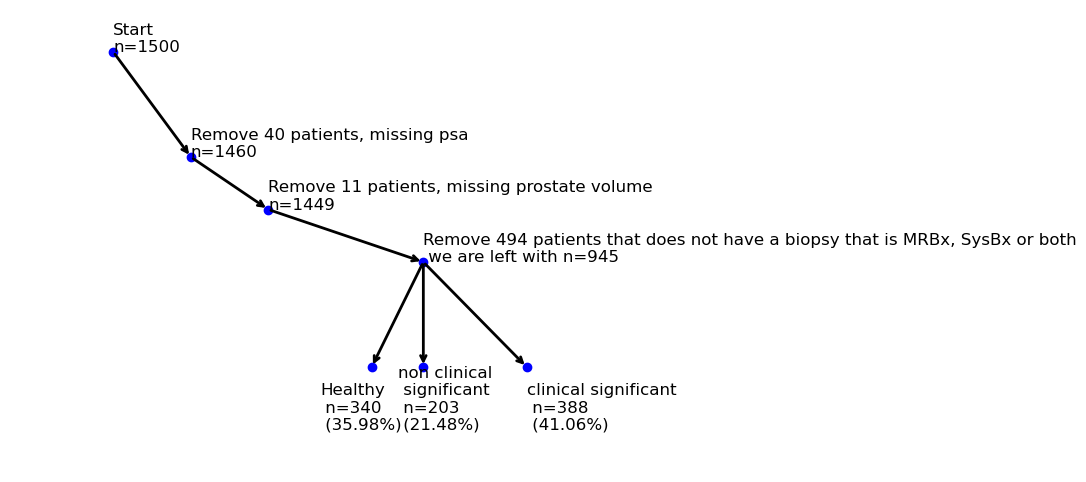

In [6]:
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
df_exploded = df



# Split the lesion_GS column by comma and explode the DataFrame to handle multiple scores
df['lesion_GS'] = df['lesion_GS'].str.split(',')
df_exploded = df.explode('lesion_GS').reset_index(drop=True)

# Group by patient_id and select the highest Gleason score for each patient
df_highest_gleason = df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()

# Merge the highest Gleason scores back to the original DataFrame
df = df.drop(columns=['lesion_GS']).merge(df_highest_gleason, on='patient_id')

# Calculate the counts for each category
gleason_7_low = df[df["lesion_GS"] == "3+3"].shape[0]
gleason_7_high = df[df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
negative_biopsy = df[df["lesion_GS"] == "0+0"].shape[0]

# Print the counts
# Count total unique patients after filtering
total = df.shape[0]

# Existing counts
counted = gleason_7_low + gleason_7_high + negative_biopsy

# Unclassified
unclassified = df[~df["lesion_GS"].isin(["0+0", "3+3", "3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])]
print(f"⚠️ Unclassified patients: {unclassified.shape[0]}")
print(unclassified["lesion_GS"].value_counts(dropna=False))
print(gleason_7_low, gleason_7_high, negative_biopsy)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([0.2, 0.35, 0.5, 0.8, 0.7, 0.8, 1], [2, 1.5, 1.25, 1, 0.5, 0.5, 0.5], 'o', color='blue')
ax.annotate("", xy=(0.35, 1.5), xytext=(0.2, 2), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.5, 1.25), xytext=(0.35, 1.5), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.8, 1), xytext=(0.5, 1.25), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.7, 0.5), xytext=(0.8, 1), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.8, 0.5), xytext=(0.8, 1), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(1, 0.5), xytext=(0.8, 1), arrowprops=dict(arrowstyle="->", lw=2))

ax.text(0.2, 2, "Start\nn=1500", fontsize=12)
ax.text(0.35, 1.5, "Remove 40 patients, missing psa \nn=1460", fontsize=12)
ax.text(0.5, 1.25, "Remove 11 patients, missing prostate volume \nn=1449", fontsize=12)
ax.text(0.8, 1, "Remove 494 patients that does not have a biopsy that is MRBx, SysBx or both\n we are left with n=945", fontsize=12)
ax.text(0.6, 0.2, f"Healthy\n n={negative_biopsy} \n ({(negative_biopsy / 945) * 100:.2f}%)", fontsize=12)
ax.text(0.75, 0.2, f"non clinical \n significant \n n={gleason_7_low} \n ({(gleason_7_low / 945) * 100:.2f}%) " , fontsize=12)
ax.text(1, 0.2, f"clinical significant\n n={gleason_7_high} \n ({(gleason_7_high / 945) * 100:.2f}%)", fontsize=12)

ax.set_xlim(0, 1.2)
ax.set_ylim(0, 2.2)
ax.axis("off")

plt.show()

In [7]:
def median_iqr(series):
    return f"{series.median():.2f} ({series.quantile(0.25):.2f}-{series.quantile(0.75):.2f})"



def generate_summary_table(df):
    N = len(df)
    age = df['patient_age']
    psa = df['psa']
    prostate_volume = df['prostate_volume']
    psad = df['psad']
    
    age_mean_std = f"{age.mean():.2f},\u2009+-\u2009 {age.std():.2f}"
    psa_median_iqr = f"{psa.mean():2f},\u2009+-\u2009 {psa.std():.2f}"

    psad_median_iqr = f"{psad.mean():2f},\u2009+-\u2009 {psad.std():.2f}"
    prostate_volume_median_std = f"{prostate_volume.median():.2f},\u2009+-\u2009 {prostate_volume.std():.2f}"


    vol_35 = prostate_volume[prostate_volume < 35].shape[0]
    vol_35_50 = prostate_volume[(prostate_volume >= 35) & (prostate_volume < 50)].shape[0]
    vol_50 = prostate_volume[prostate_volume >= 50].shape[0]

    biopsy_counts = df['histopath_type'].value_counts()
    biopsy_types = {
        'MRBx': biopsy_counts.get('MRBx', 0),
        'SysBx': biopsy_counts.get('SysBx', 0),
        'SysBx+MRBx': biopsy_counts.get('SysBx+MRBx', 0)
    }
    df['lesion_GS'] = df['lesion_GS'].str.split(',')
    df_exploded = df.explode('lesion_GS').reset_index(drop=True)

# Group by patient_id and select the highest Gleason score for each patient
    df_highest_gleason = df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()

# Merge the highest Gleason scores back to the original DataFrame
    df = df.drop(columns=['lesion_GS']).merge(df_highest_gleason, on='patient_id')

    gleason_7_low = df[df["lesion_GS"] == "3+3"].shape[0]
    gleason_7_high = df[df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
    negative_biopsy = df[df["lesion_GS"] == "0+0"].shape[0]

    table_data = {
        'Age(Years)': age_mean_std,
        'PSA(ng/ml)': psa_median_iqr,
        'PSAD(ng/ml^2)': psad_median_iqr,
        'Prostate Volume(ml)': prostate_volume_median_std,
        "< 35 mL": f"{vol_35} ({(vol_35 / len(df)) * 100:.2f}%)",
        "35 - 50 mL": f"{vol_35_50} ({(vol_35_50 / len(df)) * 100:.2f}%)",
        "> 50 mL": f"{vol_50} ({(vol_50 / len(df)) * 100:.2f}%)",
        "Biopsy type": "".join([f"{k}: {v} ({(v / len(df)) * 100:.2f}%)" for k, v in biopsy_types.items()]),
        "Biopsy results:": "",
        "Negative:": f"{negative_biopsy} ({(negative_biopsy / len(df)) * 100:.2f}%)",
        "Gleason score ≤7:": f"{gleason_7_low} ({(gleason_7_low / len(df)) * 100:.2f}%)",
        "Gleason score >7:": f"{gleason_7_high} ({(gleason_7_high / len(df)) * 100:.2f}%)",
    }
    table_df = pd.DataFrame.from_dict(table_data, orient='index', columns=[f'Patients ({N})'])
    return table_df
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
summary_table = generate_summary_table(df)
print(summary_table)

                                                        Patients (931)
Age(Years)                                             66.48, +-  7.05
PSA(ng/ml)                                        13.180301, +-  17.42
PSAD(ng/ml^2)                                       0.277683, +-  0.44
Prostate Volume(ml)                                   50.72, +-  31.39
< 35 mL                                                   192 (20.62%)
35 - 50 mL                                                245 (26.32%)
> 50 mL                                                   494 (53.06%)
Biopsy type          MRBx: 517 (55.53%)SysBx: 210 (22.56%)SysBx+MRB...
Biopsy results:                                                       
Negative:                                                 340 (36.52%)
Gleason score ≤7:                                         203 (21.80%)
Gleason score >7:                                         388 (41.68%)


In [9]:
def summarize2(df_subset):
    age = df_subset['patient_age']
    psa = df_subset['psa']
    prostate_volume = df_subset['prostate_volume']
    psad = df_subset['psad']

    vol_35 = prostate_volume[prostate_volume < 35].shape[0]
    vol_35_50 = prostate_volume[(prostate_volume >= 35) & (prostate_volume < 50)].shape[0]
    vol_50 = prostate_volume[prostate_volume >= 50].shape[0]

    biopsy_counts = df_subset['histopath_type'].value_counts()
    return {
        'Age (Years)': f"{age.mean():.2f}, ± {age.std():.2f}",
        'PSA (ng/ml)': f"{psa.mean():.2f}, ± {psa.std():.2f}",
        'PSAD (ng/ml²)': f"{psad.mean():.2f}, ± {psad.std():.2f}",
        'Prostate Volume (ml)': f"{prostate_volume.mean():.2f}, ± {prostate_volume.std():.2f}",
        "< 35 mL": f"{vol_35} ({(vol_35 / len(df_subset)) * 100:.2f}%)",
        "35–50 mL": f"{vol_35_50} ({(vol_35_50 / len(df_subset)) * 100:.2f}%)",
        "> 50 mL": f"{vol_50} ({(vol_50 / len(df_subset)) * 100:.2f}%)",
        "Biopsy Type: MRBx": f"{biopsy_counts.get('MRBx', 0)} ({(biopsy_counts.get('MRBx', 0) / len(df_subset)) * 100:.2f}%)",
        "Biopsy Type: SysBx": f"{biopsy_counts.get('SysBx', 0)} ({(biopsy_counts.get('SysBx', 0) / len(df_subset)) * 100:.2f}%)",
        "Biopsy Type: SysBx+MRBx": f"{biopsy_counts.get('SysBx+MRBx', 0)} ({(biopsy_counts.get('SysBx+MRBx', 0) / len(df_subset)) * 100:.2f}%)",
        "Negative (0+0)": f"{sum(df_subset['lesion_GS'] == '0+0')} ({(sum(df_subset['lesion_GS'] == '0+0') / len(df_subset)) * 100:.2f}%)",
        "Gleason = 3+3": f"{sum(df_subset['lesion_GS'] == '3+3')} ({(sum(df_subset['lesion_GS'] == '3+3') / len(df_subset)) * 100:.2f}%)",
        "Gleason ≥ 3+4": f"{sum(df_subset['group'] == 'csPCa')} ({(sum(df_subset['group'] == 'csPCa') / len(df_subset)) * 100:.2f}%)",
    }

def generate_four_column_summary(df):
    # Explode lesion_GS into multiple rows per patient
    df['lesion_GS'] = df['lesion_GS'].str.split(',')
    df_exploded = df.explode('lesion_GS').reset_index(drop=True)

    # Get highest Gleason score per patient
    df_highest = df_exploded.groupby('patient_id')['lesion_GS'].apply(get_highest_gleason_score).reset_index()
    df = df.drop(columns=['lesion_GS']).merge(df_highest, on='patient_id')

    df['lesion_GS'] = df['lesion_GS'].str.strip()

    # Classify based on Gleason score
    def classify_gleason(gs):
        if gs in ["3+4", "4+3", "4+4", "5+4", "4+5", "5+5", "3+5", "5+3"]:
            return 'csPCa'
        elif gs == "3+3":
            return 'non-csPCa'
        elif gs == "0+0":
            return 'negative'
        else:
            return 'other'

    df['group'] = df['lesion_GS'].apply(classify_gleason)

    df_all = df
    df_csPCa = df[df['group'] == 'csPCa']
    df_non_csPCa = df[df['group'] == 'non-csPCa']
    df_negative = df[df['group'] == 'negative']

    # Generate summaries

    cs_summary = summarize2(df_csPCa)
    non_cs_summary = summarize2(df_non_csPCa)
    neg_summary = summarize2(df_negative)

    return pd.DataFrame({
        f"Clinically Significant (N={len(df_csPCa)})": cs_summary,
        f"Non-significant (3+3) (N={len(df_non_csPCa)})": non_cs_summary,
        f"Negative (0+0) (N={len(df_negative)})": neg_summary
    })

# Usage
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
summary_table = generate_four_column_summary(df)
print(summary_table)

                        Clinically Significant (N=388)  \
Age (Years)                              67.83, ± 6.89   
PSA (ng/ml)                             16.26, ± 21.32   
PSAD (ng/ml²)                             0.36, ± 0.53   
Prostate Volume (ml)                    53.41, ± 27.29   
< 35 mL                                    95 (24.48%)   
35–50 mL                                  113 (29.12%)   
> 50 mL                                   180 (46.39%)   
Biopsy Type: MRBx                         236 (60.82%)   
Biopsy Type: SysBx                         47 (12.11%)   
Biopsy Type: SysBx+MRBx                   105 (27.06%)   
Negative (0+0)                               0 (0.00%)   
Gleason = 3+3                                0 (0.00%)   
Gleason ≥ 3+4                            388 (100.00%)   

                        Non-significant (3+3) (N=203) Negative (0+0) (N=340)  
Age (Years)                             67.56, ± 6.53          64.29, ± 7.02  
PSA (ng/ml)                  

In [13]:
fileInfoT2w = '_t2w.mha'

fileInfo = '.nii.gz'
t2w_paths = find_t2W_files(source_PI_CAI, fileInfoT2w)
Guerbet23_nii_gz_paths = find_t2W_files(source_PI_CAI_whole_gland_Guerbet23, fileInfo)

In [1]:
def generate_summary_table_train_test(df, X_train, X_test):
    N = len(df)
    age = df['patient_age']
    age_train = X_train['patient_age']
    age_test = X_test['patient_age']
    psa = df['psa']
    psa_train = X_train['psa']
    psa_test = X_test['psa']
    prostate_volume = df['prostate_volume']
    prostate_volume_train = X_train['prostate_volume']
    prostate_volume_test = X_test['prostate_volume']
    psad = df['psad']
    psad_train = X_train['psad']
    psad_test = X_test['psad']
    
    age_mean_std = f"{age.mean():.2f},\u2009+-\u2009 {age.std():.2f}"
    age_train_mean_std = f"{age_train.mean():.2f},\u2009+-\u2009 {age_train.std():.2f}"
    age_test_mean_std = f"{age_test.mean():.2f},\u2009+-\u2009 {age_test.std():.2f}"
    psa_median_iqr = f"{psa.mean():.2f},\u2009+-\u2009 {psa.std():.2f}"
    psa_train_median_iqr = f"{psa_train.mean():.2f},\u2009+-\u2009 {psa_train.std():.2f}"
    psa_test_median_iqr = f"{psa_test.mean():.2f},\u2009+-\u2009 {psa_test.std():.2f}"
    psad_median_iqr = f"{psad.mean():.2f},\u2009+-\u2009 {psad.std():.2f}"
    psad_train_median_iqr = f"{psad_train.mean():.2f},\u2009+-\u2009 {psad_train.std():.2f}"
    psad_test_median_iqr = f"{psad_test.mean():.2f},\u2009+-\u2009 {psad_test.std():.2f}"
    prostate_volume_median_std = f"{prostate_volume.mean():.2f},\u2009+-\u2009 {prostate_volume.std():.2f}"
    prostate_volume_train_median_std = f"{prostate_volume_train.mean():.2f},\u2009+-\u2009 {prostate_volume_train.std():.2f}"
    prostate_volume_test_median_std = f"{prostate_volume_test.mean():.2f},\u2009+-\u2009 {prostate_volume_test.std():.2f}"


    vol_35 = prostate_volume[prostate_volume < 35].shape[0]
    vol_35_train = prostate_volume_train[prostate_volume_train < 35].shape[0]
    vol_35_test = prostate_volume_test[prostate_volume_test < 35].shape[0]
    vol_35_50 = prostate_volume[(prostate_volume >= 35) & (prostate_volume < 50)].shape[0]
    vol_35_50_train = prostate_volume_train[(prostate_volume_train >= 35) & (prostate_volume_train < 50)].shape[0]
    vol_35_50_test = prostate_volume_test[(prostate_volume_test >= 35) & (prostate_volume_test < 50)].shape[0]
    vol_50 = prostate_volume[prostate_volume >= 50].shape[0]
    vol_50_train = prostate_volume_train[prostate_volume_train >= 50].shape[0]
    vol_50_test = prostate_volume_test[prostate_volume_test >= 50].shape[0]

    biopsy_counts = df['histopath_type'].value_counts()
    biopsy_counts_train = X_train['histopath_type'].value_counts()
    biopsy_counts_test = X_test['histopath_type'].value_counts()
    biopsy_types = {
        'MRBx': biopsy_counts.get('MRBx', 0),
        'SysBx': biopsy_counts.get('SysBx', 0),
        'SysBx+MRBx': biopsy_counts.get('SysBx+MRBx', 0)
    }
    biopsy_types_train = {
        'MRBx': biopsy_counts_train.get('MRBx', 0),
        'SysBx': biopsy_counts_train.get('SysBx', 0),
        'SysBx+MRBx': biopsy_counts_train.get('SysBx+MRBx', 0)
    }
    biopsy_types_test = {
        'MRBx': biopsy_counts_test.get('MRBx', 0),
        'SysBx': biopsy_counts_test.get('SysBx', 0),
        'SysBx+MRBx': biopsy_counts_test.get('SysBx+MRBx', 0)
    }
    test_df = X_test
    train_df = X_train

    df['lesion_GS'] = df['lesion_GS'].str.split(',')
    train_df['lesion_GS'] = train_df['lesion_GS'].str.split(',')
    test_df['lesion_GS'] = test_df['lesion_GS'].str.split(',')

    df_exploded = df.explode('lesion_GS').reset_index(drop=True)
    train_df_exploded = train_df.explode('lesion_GS').reset_index(drop=True)
    test_df_exploded = test_df.explode('lesion_GS').reset_index(drop=True)

    df_highest_gleason = df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()
    train_df_highest_gleason = train_df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()
    test_df_highest_gleason = test_df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()

    df = df.drop(columns=['lesion_GS']).merge(df_highest_gleason, on='patient_id')
    train_df = train_df.drop(columns=['lesion_GS']).merge(train_df_highest_gleason, on='patient_id')
    test_df = test_df.drop(columns=['lesion_GS']).merge(test_df_highest_gleason, on='patient_id')

    gleason_7_low = df[df["lesion_GS"] == "3+3"].shape[0]
    gleason_7_low_train = train_df[train_df["lesion_GS"] == "3+3"].shape[0]
    gleason_7_low_test = test_df[test_df["lesion_GS"] == "3+3"].shape[0]
    gleason_7_high = df[df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
    gleason_7_high_train = train_df[train_df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
    gleason_7_high_test = test_df[test_df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
    negative_biopsy = df[df["lesion_GS"] == "0+0"].shape[0]
    negative_biopsy_train = train_df[train_df["lesion_GS"] == "0+0"].shape[0]
    negative_biopsy_test = test_df[test_df["lesion_GS"] == "0+0"].shape[0]

    table_data = {
        'Age(Years)': [age_mean_std, age_train_mean_std, age_test_mean_std],
        'PSA(ng/ml)': [psa_median_iqr, psa_train_median_iqr, psa_test_median_iqr],
        'PSAD(ng/ml^2)': [psad_median_iqr, psad_train_median_iqr, psad_test_median_iqr],
        'Prostate Volume(ml)': [prostate_volume_median_std, prostate_volume_train_median_std, prostate_volume_test_median_std],
        "< 35 mL": [f"{vol_35} ({(vol_35 / len(df)) * 100:.2f}%)", f"{vol_35_train} ({(vol_35_train / len(X_train)) * 100:.2f}%)", f"{vol_35_test} ({(vol_35_test / len(X_test)) * 100:.2f}%)"],
        "35 - 50 mL": [f"{vol_35_50} ({(vol_35_50 / len(df)) * 100:.2f}%)", f"{vol_35_50_train} ({(vol_35_50_train / len(X_train)) * 100:.2f}%)", f"{vol_35_50_test} ({(vol_35_50_test / len(X_test)) * 100:.2f}%)"],
        "> 50 mL": [f"{vol_50} ({(vol_50 / len(df)) * 100:.2f}%)", f"{vol_50_train} ({(vol_50_train / len(X_train)) * 100:.2f}%)", f"{vol_50_test} ({(vol_50_test / len(X_test)) * 100:.2f}%)"],
        "Biopsy type": ["".join([f"{k}: {v} ({(v / len(df)) * 100:.2f}%)" for k, v in biopsy_types.items()]), "".join([f"{k}: {v} ({(v / len(X_train)) * 100:.2f}%)" for k, v in biopsy_types_train.items()]), "".join([f"{k}: {v} ({(v / len(X_test)) * 100:.2f}%)" for k, v in biopsy_types_test.items()]),
        ],
        "Biopsy results:": "",
        "Negative:": [f"{negative_biopsy} ({(negative_biopsy / len(df)) * 100:.2f}%)", f"{negative_biopsy_train} ({(negative_biopsy_train / len(X_train)) * 100:.2f}%)", f"{negative_biopsy_test} ({(negative_biopsy_test / len(X_test)) * 100:.2f}%)"],
        "Gleason score ≤7:": [f"{gleason_7_low} ({(gleason_7_low / len(df)) * 100:.2f}%)", f"{gleason_7_low_train} ({(gleason_7_low_train / len(X_train)) * 100:.2f}%)", f"{gleason_7_low_test} ({(gleason_7_low_test / len(X_test)) * 100:.2f}%)"],
        "Gleason score >7:": [f"{gleason_7_high} ({(gleason_7_high / len(df)) * 100:.2f}%)", f"{gleason_7_high_train} ({(gleason_7_high_train / len(X_train)) * 100:.2f}%)", f"{gleason_7_high_test} ({(gleason_7_high_test / len(X_test)) * 100:.2f}%)"],
    }

    table_df = pd.DataFrame.from_dict(table_data,  orient='index', columns=[f'Patients ({N})', 'Train','Test'])
    return table_df


def get_class_distribution(df, dataset_name):
    """Get counts of non-csPCa and csPCa from the binary case_csPCa column."""
    value_counts = df['case_csPCa'].value_counts().to_dict()
    non_csPCa = value_counts.get(0, 0)
    csPCa = value_counts.get(1, 0)
    
    return pd.DataFrame({
        'Dataset': [dataset_name, dataset_name],
        'Class': ['non-csPCa', 'csPCa'],
        'Count': [non_csPCa, csPCa]
    })

def plot_full_class_distribution(y_full, y_train, y_test):
    """
    Plots class distribution for original, train, test, and external validation datasets.
    Assumes labels are 0 (non_csPCa) and 1 (csPCa).
    """
    datasets = {
        "Original Set": y_full,
        "Training Set": y_train,
        "Test Set": y_test,
    }

    colors = ['skyblue', 'lightgreen', 'lightcoral', 'orange']
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes = axes.flatten()

    for i, (title, y_data) in enumerate(datasets.items()):
        ax = axes[i]
        counts = y_data.value_counts().sort_index()
        total = counts.sum()
        bars = ax.bar(counts.index.astype(str), counts, color=colors[i], width=0.6)
        ax.set_title(f'Class Distribution in {title}')
        ax.set_xlabel('Class')
        ax.set_ylabel('Count')
        for bar, count in zip(bars, counts):
            percent = (count / total) * 100
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                    f'{count}\n({percent:.2f}%)', ha='center', va='bottom', fontsize=9)
        ax.set_ylim(0, max(counts) * 1.25)  # Add headroom

    plt.tight_layout()
    plt.show()

In [20]:
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')


# Split the data into train and test sets
X = df.drop(columns=['case_csPCa'])
y = df['case_csPCa']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
summary_table = generate_summary_table_train_test(df, X_train, X_test)

print(summary_table)

                                                        Patients (931)  \
Age(Years)                                             66.48, +-  7.05   
PSA(ng/ml)                                            13.18, +-  17.42   
PSAD(ng/ml^2)                                           0.28, +-  0.44   
Prostate Volume(ml)                                   58.28, +-  31.39   
< 35 mL                                                   192 (20.62%)   
35 - 50 mL                                                245 (26.32%)   
> 50 mL                                                   494 (53.06%)   
Biopsy type          MRBx: 517 (55.53%)SysBx: 210 (22.56%)SysBx+MRB...   
Biopsy results:                                                   None   
Negative:                                                 340 (36.52%)   
Gleason score ≤7:                                         203 (21.80%)   
Gleason score >7:                                         388 (41.68%)   

                                     

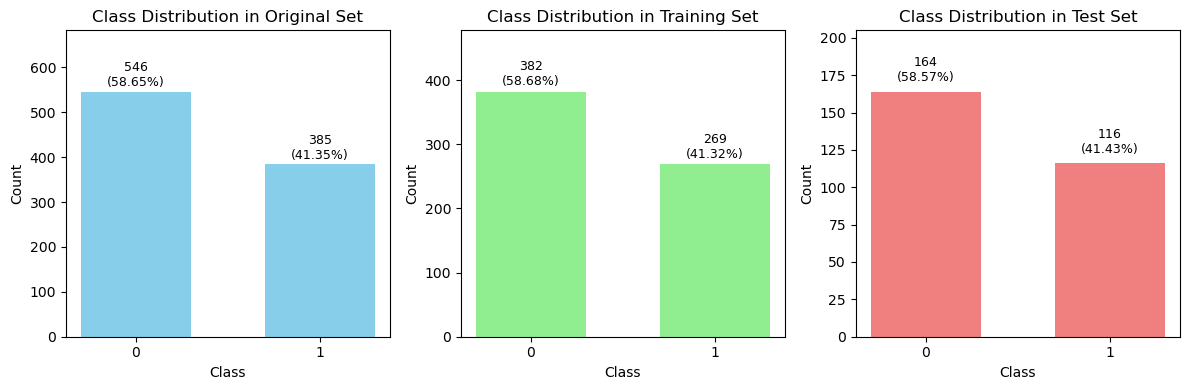

In [38]:
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')


# Split the data into train and test sets
X = df.drop(columns=['case_csPCa'])
y = df['case_csPCa']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
plot_full_class_distribution(y, y_train, y_test)

In [ ]:
NEW_SPACING = (0.5, 0.5, 3.0)
def resample_image(image, new_spacing):
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()


    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(original_size)
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetTransform(sitk.Transform())
    resampler.SetInterpolator(sitk.sitkLinear)

    return resampler.Execute(image)

def normalize_image(image):
    image = sitk.Cast(image, sitk.sitkFloat32)
    min_intensity = sitk.GetArrayFromImage(image).min()
    max_intensity = sitk.GetArrayFromImage(image).max()
    normalize_image = (image - min_intensity) / (max_intensity - min_intensity)
    return normalize_image


def process_mha_files(t2w_folder, output_folder):
    """Processes all .mha files in the input folder and saves resampled versions."""
    if not os.path.exists(t2w_folder):
        print(f"ERROR: Input folder does not exist! Check path: {t2w_folder}")
        return
    
    os.makedirs(output_folder, exist_ok=True)
    
    patient_folders = [os.path.join(t2w_folder, d) for d in os.listdir(t2w_folder) if os.path.isdir(os.path.join(t2w_folder, d))]
    print(f"Total patient folders found: {len(patient_folders)}")

    total_processed = 0
    
    for patient_folder in patient_folders:
        patient_id = os.path.basename(patient_folder)
        print(f"\n🔍 Checking folder: {patient_folder}")
        actual_files = os.listdir(patient_folder)
        print(f"Files found: {actual_files}")
        
        t2w_files = [f for f in actual_files if f.endswith("_t2w.mha")]
        if not t2w_files:
            print(f"⚠️ No _t2w.mha file found in {patient_folder} (Skipping)")
            continue

        t2w_path = os.path.join(patient_folder, t2w_files[0])
        print(f"Processing: {t2w_path}")
        study_id = t2w_files[0].split('_')[1]
        output_path = os.path.join(output_folder, f"{patient_id}_{study_id}_t2w_resampled.mha")
        print(f"Processing {t2w_path}...")

        try:
            image = sitk.ReadImage(t2w_path)
            resampled_image = resample_image(image, NEW_SPACING)
            normalized_image = normalize_image(resampled_image)
            sitk.WriteImage(normalized_image, output_path)
            print(f"Saved resampled image to {output_path}")
            total_processed += 1
        except Exception as e:
            print(f"ERROR processing {patient_id}: {e}")

    print(f"Processing complete. Total images resampled: {total_processed}")

def process_mask_files(input_folder, output_folder):
    """Processes all .mha files in the input folder and saves resampled versions."""
    if not os.path.exists(input_folder):
        print(f"ERROR: Input folder does not exist! Check path: {input_folder}")
        return
    
    os.makedirs(output_folder, exist_ok=True)
    

    total_processed = 0
    
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.nii.gz'):
            input_path = os.path.join(input_folder, file_name)
            print(f"\n🔍 Checking folder: {input_path}")

            patient_id, study_id = file_name.split('_')[:2]
            output_path = os.path.join(output_folder, f"{patient_id}_{study_id}")
            print(f"Processing: {file_name}")

            try:
                image = sitk.ReadImage(input_path)
                resampled_image = resample_image(image, NEW_SPACING)
                normalized_image = normalize_image(resampled_image)
                sitk.WriteImage(normalized_image, output_path)
                print(f"Saved resampled image to {output_path}")
                total_processed += 1
            except Exception as e:
                print(f"ERROR processing {file_name}: {e}")

    print(f"Processing complete. Total images resampled: {total_processed}")

In [ ]:

t2w_folder0 = r"Data\picai_public_images\picai_public_images_fold0"
t2w_folder1 = r"Data\picai_public_images\picai_public_images_fold1"
t2w_folder2 = r"Data\picai_public_images\picai_public_images_fold2"
t2w_folder3 = r"Data\picai_public_images\picai_public_images_fold3"
t2w_folder4 = r"Data\picai_public_images\picai_public_images_fold4"
output_folder0 = r"Data\t2w_spacing_resampled2\resampled0"
output_folder1 = r"Data\t2w_spacing_resampled2\resampled1"
output_folder2 = r"Data\t2w_spacing_resampled2\resampled2"
output_folder3 = r"Data\t2w_spacing_resampled2\resampled3"
output_folder4 = r"Data\t2w_spacing_resampled2\resampled4"
process_mha_files(t2w_folder0, output_folder0)
process_mha_files(t2w_folder1, output_folder1)
process_mha_files(t2w_folder2, output_folder2)
process_mha_files(t2w_folder3, output_folder3)
process_mha_files(t2w_folder4, output_folder4)

In [ ]:
Guerbet_23_resampled = r"Data\Guerbet23_resampled2"


process_mask_files(source_PI_CAI_whole_gland_Guerbet23, Guerbet_23_resampled)

In [ ]:
def check_processed_images(output_folder, expected_spacing):
    """
    Check if the images in the output folder have been correctly resampled and normalized.
    """
    if not os.path.exists(output_folder):
        print(f"ERROR: Output folder does not exist! Check path: {output_folder}")
        return
    
    processed_files = [f for f in os.listdir(output_folder) if f.endswith(".mha")]
    if not processed_files:
        print(f"No processed files found in {output_folder}")
        return
    
    for file in processed_files:
        file_path = os.path.join(output_folder, file)
        image = sitk.ReadImage(file_path)
        
        # Check spacing
        spacing = image.GetSpacing()
        if spacing != expected_spacing:
            print(f"ERROR: Image {file} has incorrect spacing: {spacing}")
        else:
            print(f"Image {file} has correct spacing: {spacing}")
        
        # Check intensity range
        array = sitk.GetArrayFromImage(image)
        min_intensity = array.min()
        max_intensity = array.max()
        if min_intensity < 0 or max_intensity > 1:
            print(f"ERROR: Image {file} has incorrect intensity range: [{min_intensity}, {max_intensity}]")
        else:
            print(f"Image {file} has correct intensity range: [{min_intensity}, {max_intensity}]")

# Example usage
output_folder0 = r"Data\t2w_spacing_resampled\resampled0"
expected_spacing = (0.5, 0.5, 3.0)
check_processed_images(output_folder0, expected_spacing)